# cluster stocks

The data came from Kaggle : https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs This includes ETF and Stock data. We only use stock data. The purpose of this project is to cluster stocks based on its return, volatility and volume. The stocks are naturally grouped into sectors, but some stocks may have internal similarities that cannot be found based on sector. Therefore, we try to see the similarities of stocks within each cluster.

In [1]:
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import mixture
import matplotlib.pyplot as plt 
file_list=glob.glob('./Stocks/*.txt')
train_list=[]
test_list=[]
index=0
for file in file_list:
    index+=1
    name=(str(file).replace('/','.')).split('.')
    company=name[-3]
    
    table=pd.read_csv(file,sep=",")
    pd.to_datetime(table['Date'])
    test=table[table['Date']>'2016-12-31']
    test=test.set_index('Date')
    test=test[['Close']]
    test.columns=[company.strip()]
    table=table[(table['Date']>'2016-01-01') & (table['Date']<'2016-12-31')]
    table['Return']=(table['Close']-table['Open'])/table['Open']
    table['Max-Min']=(table['High']-table['Low'])/table['Low']
    table=table[['Return','Volume','Max-Min']]
    table['Return']=table['Return'].mean()
    table['Max-Min']=table['Max-Min'].mean()
    table['Volume']= table['Volume'].mean()
    table['company']=company.strip()
    table=table.head(1)
    train_list.append(table)
    test_list.append(test)
 
    if index == 1000:
        break

use train_list to get the whole dataframe for training

In [2]:
train_data=pd.concat(train_list)

In [3]:

scaler = StandardScaler()
train_data[['Return','Volume','Max-Min']]= scaler.fit_transform(train_data[['Return','Volume','Max-Min']])

use GMM model and use BIC to choose the best model

In [4]:
c_type=['full', 'tied', 'diag', 'spherical']
min_bic=1000000
best_c=None
best_n=None
for i in range(1,15):
    for cv_type in c_type:
        model=mixture.GaussianMixture(n_components=i,covariance_type=cv_type)
        model.fit(train_data[['Return','Volume','Max-Min']])
        #print(model.bic(train_data[['Return','Volume','Max-Min']]))
        if model.bic(train_data[['Return','Volume','Max-Min']])<min_bic:
            min_bic=model.bic(train_data[['Return','Volume','Max-Min']])
            best_c=cv_type
            best_n=i
print(best_c)
print(best_n)
print(min_bic)

diag
13
-7729.3707934106615


In [5]:
model=mixture.GaussianMixture(n_components=10,covariance_type=best_c)
group=model.fit_predict(train_data[['Return','Volume','Max-Min']])


In [6]:
color=['yellow','blue','black','pink','green','grey','purple','red','orange','brown']
group=dict(zip(train_data['company'].tolist(),group.tolist()))

In [7]:
test_data= pd.concat(test_list, axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
columns=test_data.columns
test_data=pd.DataFrame(scaler.fit_transform(test_data))
test_data.columns=columns
test_data=test_data.dropna(axis=1)

here we can visualize the performance of each cluster 

In [9]:

columns=test_data.columns
def plot_each_cluster(columns):
    for column in columns:
        data=test_data[column].tolist()
        time=test_data.index.tolist()
        plt.plot(time, data, color=color[group[column]])

    plt.title('Test data ')
    plt.xlabel('Time')
    plt.ylabel('close price')

    plt.show()

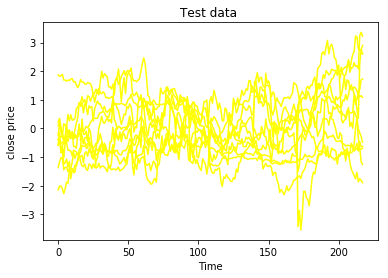

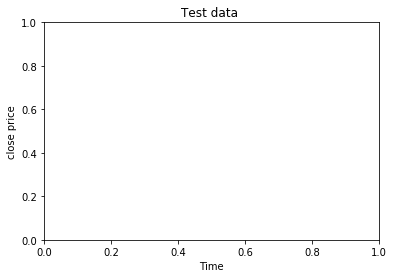

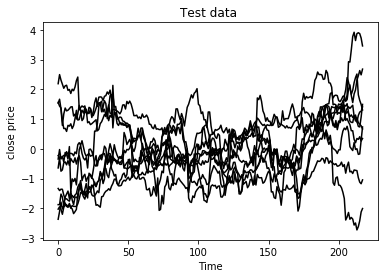

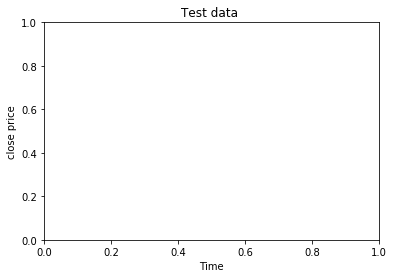

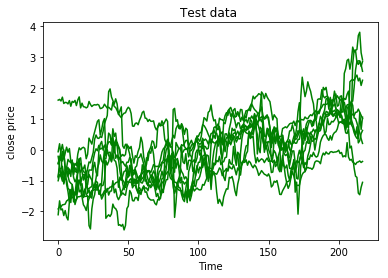

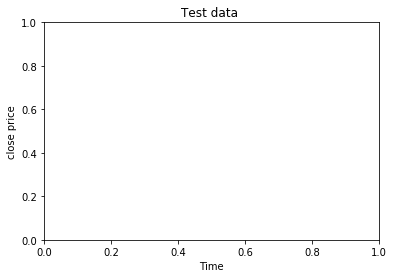

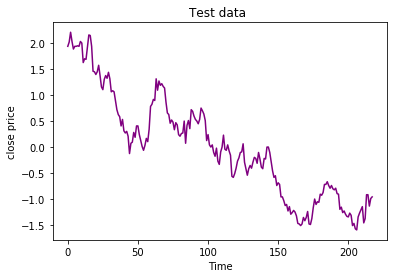

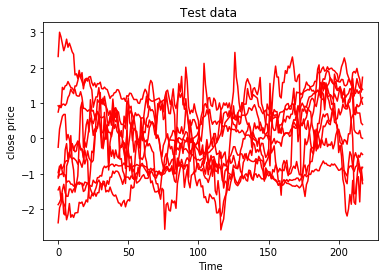

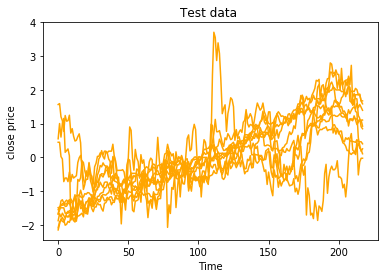

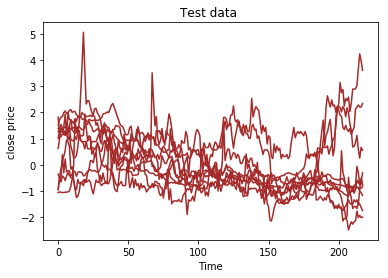

In [10]:
for i in range(10):
    cluster_col=[key for key,value in group.items() if value==i and key in columns]
    plot_each_cluster(cluster_col[:10])

In [11]:
import numpy as np
def get_cov(columns):
    return np.cov(np.transpose(test_data[columns].values))

We use the average covariance within each group to represent the similarity of each group. 
We can find out that covariance within each group is much higher

In [12]:
mean_cov=[]
all_cov=get_cov(columns).mean()
for i in range(10):
    cluster_col=[key for key,value in group.items() if value==i and key in columns]
    mean_cov.append(get_cov(cluster_col).mean())
print(mean_cov)
print(all_cov)

[0.06741287918549994, nan, 0.1593071720810475, nan, 0.11556406169224877, nan, 1.0046082949308757, 0.06878703368945235, 0.3828843100517959, 0.08369326922854803]
0.07024917497449873


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


cluster 9 is the best cluster with high similarity and increasing trend